<a href="https://colab.research.google.com/github/AntonioCCosta/DPG_PhysicsBehavior_2026/blob/main/notebooks/notebook_1_theory_dw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Physics of Behavior Tutorial II - Part 1

Animal behavior is intrinsically multiscale in nature. Yet, most descriptions focus on specific timescales of interest, and miss out on the interactions across timescales. In this tutorial, we will introduce guiding principles for building a multiscale description of behavior. In particular, we will use the notion of timescale separation for distinguishing behavioral states from transitions on different timescales, using the language of transfer operators.

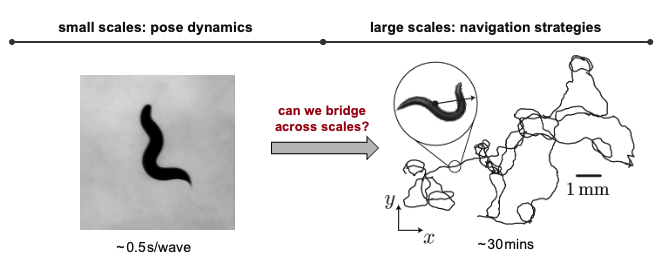


We have split the tutorial notebooks into 4 sections, starting with a theoretical presentation of the use of transfer operators for coarse-graining dynamics through a timescale separation ([Notebook 1](https://colab.research.google.com/github/AntonioCCosta/DPG_PhysicsBehavior_2026/blob/main/notebooks/notebook_1.ipynb)), then moving into a couple of toy data examples ([Notebook 2](https://colab.research.google.com/github/AntonioCCosta/DPG_PhysicsBehavior_2026/blob/main/notebooks/notebook_2.ipynb) and [Notebook 3](https://colab.research.google.com/github/AntonioCCosta/DPG_PhysicsBehavior_2026/blob/main/notebooks/notebook_3.ipynb)), and finally ended with a real-world data application to C. elegans posture dynamics ([Notebook 4](https://colab.research.google.com/github/AntonioCCosta/DPG_PhysicsBehavior_2026/blob/main/notebooks/notebook_4.ipynb)).


Before we start, load the following python packages:

In [1]:
# Environment setup
!pip install -q -r https://raw.githubusercontent.com/AntonioCCosta/DPG_PhysicsBehavior_2026/main/requirements.txt

In [2]:
import os

if not os.path.exists("DPG_PhysicsBehavior_2026"):
    !git clone https://github.com/AntonioCCosta/DPG_PhysicsBehavior_2026.git
else:
    %cd DPG_PhysicsBehavior_2026
    !git pull
    %cd ..

import sys, platform
print("Python:", sys.version)
print("Platform:", platform.platform())

/content/DPG_PhysicsBehavior_2026
Already up to date.
/content
Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Platform: Linux-6.6.113+-x86_64-with-glibc2.35


In [3]:
import h5py
import numpy as np
import numpy.ma as ma
sys.path.append('./DPG_PhysicsBehavior_2026/utils')
import operator_calculations as op_calc
import delay_embedding as embed
import partition_methods as cl
import coarse_graining as cgm
import matplotlib.pyplot as plt

## Stochastic dynamics on a 1d double well

From an abstract perspective, we will think of behavior as a dynamical system,

$$
\dot{\mathbf{x}} = f(\mathbf{x},\theta),
$$

where $\mathbf{x}\in \mathbb{R}^D$ represents the behavioral state, which corresponds to the full set of variables needed to predict the future behavioral state, $\theta$ is an unknown set of parameters, and $f$ is a nonlinear noisy function of the state.

Generally speaking, when studying animal behavior, we don't have access to $f$ or $\theta$, or not even $\mathbf{x}$, but in this tutorial we will see how we can still learn effective models and representations of behavior spanning multiple timescales.

To gain intuition of the theoretical approach, let's start with a simple system, for which the long-lived dynamics can be derived analytically.

We will be considering overdamped Langevin dynamics on a potential landscape,

$$
\dot{x} = -\partial_x V(x) + \sqrt{2 T_x}\,\eta(t),
\qquad \langle \eta(t)\eta(t') \rangle = \delta(t-t').
$$

Where the potential landscape is a double well:

$$
V(x) = \frac{x^4}{4} -\mu \frac{x^2}{2}
$$

For $\mu>0$, we have two stable fixed points with an energy barrier in between. You can think of each well as representing a behavioral state, and the transition dynamics as being set by stochastic transitions among wells.


> Comment: while the full dynamics should include position and momentum, we here study the **overdamped** limit for simplicity. By overdamped we mean that velocity fluctuations are much faster that the position fluctuations, since friction is much larger than the mass (see e.g. Risken, *The Fokker-Planck Equation: Methods of Solution and Applications*, 1989), and so we can effectively neglect the velocity dynamics. This holds, for example, for tiny particles in viscuous fluids.




Let's see what the dynamics looks like by making some simulations using a simpler Euler scheme. To gain intuition for the behavior of the system, we will plot example simulations for different values of $\mu$


In [4]:
from numba import jit,prange
@jit(nopython=True, parallel=True)
def simulate_dw(x0s,mu, Tx, dt, max_iters,downsampling):
    n_sims = len(x0s)
    sims = np.zeros((n_sims, int(max_iters/downsampling)))
    for ks in prange(n_sims):
        x0 = x0s[ks]
        x = x0
        for i in range(max_iters):
            new_x = x + (-x**3+mu*x) * dt + np.sqrt(2 * Tx) * np.random.normal(0, np.sqrt(dt))
            x = new_x
            if i%downsampling==0:
                sims[ks, int(i/downsampling)] = x
    return sims

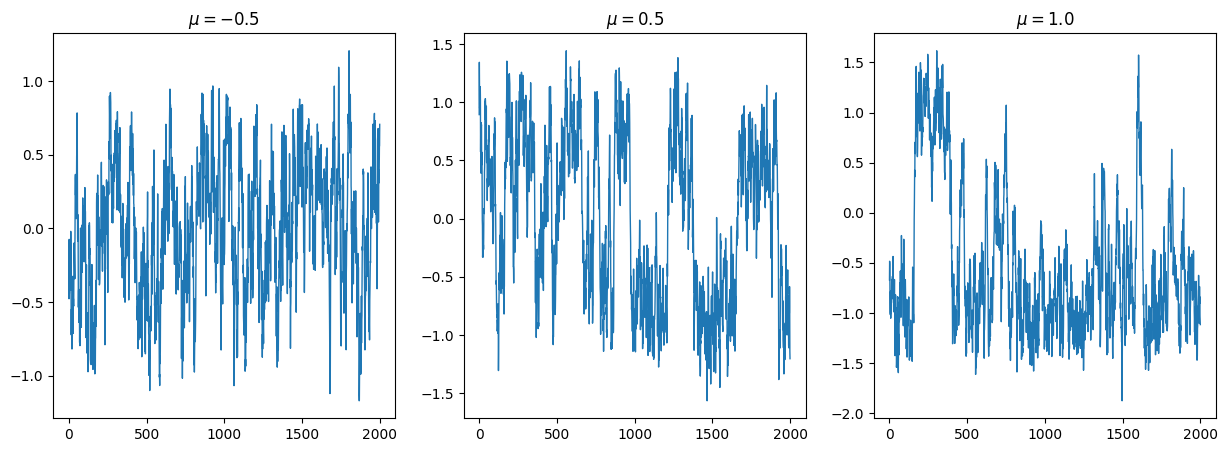

In [5]:

#set simulation parameters
Tx=2e-1 #temperature
T = 200
dt=1e-3
max_iters=int(T/dt)
final_dt = 1e-1
downsampling = int(final_dt/dt)

plt.figure(figsize=(15,5))
mu_vals = [-0.5,0.5,1]
for k in range(len(mu_vals)):
  mu=mu_vals[k]
  x0s = np.random.uniform(-1,1,1)
  sim = simulate_dw(x0s,mu, Tx, dt, max_iters,downsampling)[0]
  plt.subplot(1,3,k+1)
  plt.title(r'$\mu = {:.1f}$'.format(mu))
  plt.plot(sim,lw=1)
plt.show()

As you can see, depending on the value of $\mu$ the macroscopic properties of the dynamics change. When $\mu<0$ we have one stable fixed point, whereas $\mu > 0$ induces a pitchfork bifurcations with two stable fixed points trapping the dynamics on long timescales

At large times, the system relaxes to a steady-state distribution, which can be obtained by solving for the stationary solution of the Fokker-Planck equation (see e.g. Risken, *The Fokker-Planck Equation: Methods of Solution and Applications*, 1989),

$$
\partial_t \pi(x,t) = \partial_x\!\left(\partial_x V(x)\,\pi(x,t) \right) + T_x \partial_x^2 \pi(x,t) = -\partial_x J(x,t) = 0,
$$

where $ J(x,t)$ is the probability current. For a confining potential $V(x)$ (such as a double-well potential), normalizability of the stationary distribution implies vanishing current, $J(x) = 0$, leading to

$$
\pi(x) = e^{-V(x)/T_x}/Z,
$$

where Z is a normalization constant (analogous to the partition function). To illustrate this result, we now perform numerical simulations for a fixed value of $\mu$, and then plot the potential landscape as well as the histogram of the visited states against the Boltzmann distribution.


In [6]:

Tx=2e-1 #temperature
mu=1

T = 1000
dt=1e-3
max_iters=int(T/dt)
final_dt = 1e-1
downsampling = int(final_dt/dt)
n_sims = 100
x0s = np.random.uniform(-1,1,n_sims)
sims = simulate_dw(x0s,mu, Tx, dt, max_iters,downsampling)

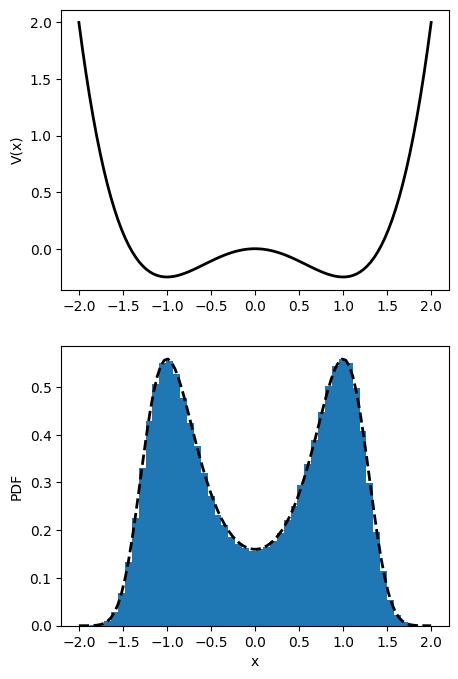

In [7]:
def potential(x,mu):
    return x**4 / 4 - mu * x**2 / 2

x = np.linspace(-2,2,100)
plt.figure(figsize=(5,8))
plt.subplot(2,1,1)
plt.plot(x,potential(x,mu),lw=2,c='k')
plt.ylabel('V(x)')
pB = np.exp(-potential(x,mu)/Tx)
Z = np.trapezoid(pB,x)
pB =pB/Z
plt.subplot(2,1,2)
plt.hist(np.hstack(sims),bins=50,density=True,label='sim')
plt.plot(x,pB,c='k',ls='--',lw=2,label='pB')
plt.xlabel('x')
plt.ylabel('PDF')
plt.show()

Now, besides the long term behavior, we also see that when $\mu>>0$ there is a strong time scale separation between the transitions among wells, and the relaxation to a single well. The time it takes to transition from one well to the other is given by the distribution (see e.g. Risken, *The Fokker-Planck Equation: Methods of Solution and Applications*, 1989),

$$
f(t,\omega) = \omega e^{-\omega t}
$$

where $\omega$ is the rate of transitions among wells. When $\mu/T_x>>1$, this is given asymptotically by the Kramers rate (see, e.g. Hänggi, "Reaction-rate theory: fifty years after Kramers." Reviews of modern physics 1990):


$$
  \omega = \frac{V''(x_0) |V''(x_b)|}{2\pi}e^{-(V(x_b)-V(x_0))/ T_x},
$$
where $x_0$ and $x_b$ correspond to a minumum and the maximum of the potential and $V''(x)$ represents the second derivative of the potential.


Let's see how this compares with the timescales we obtain from our simulations. We will estimate the time spent in each well (which should be roughly half of the Kramers's time, which captures the overall transition among two wells). Let's verify


In [8]:
def kramers_rate(mu, Tx):
    # Well minimum
    x_m = np.sqrt(mu)
    # Barrier top
    x_s = 0.0

    V = lambda x,mu: x**4/4-mu*x**2/2

    # Second derivatives
    Vpp_m = 3 * x_m**2 - mu  # V''(x_m)
    Vpp_s = 3 * x_s**2 - mu  # V''(x_s)

    # Barrier height
    DeltaV = V(x_s, mu) - V(x_m, mu)

    # Kramers rate (overdamped, 1D)
    k = np.sqrt(abs(Vpp_s) * Vpp_m) / (2 * np.pi) * np.exp(-DeltaV / Tx)
    return k

In [9]:
def state_lifetime(states,tau):
    durations=[]
    for state in np.sort(np.unique(states.compressed())):
        gaps = states==state
        gaps_boundaries = np.where(np.abs(np.diff(np.concatenate([[False], gaps, [False]]))))[0].reshape(-1, 2)
        durations.append(np.hstack(np.diff(gaps_boundaries))*tau)
    return durations

delta=1e-2*np.sqrt(mu)
xs = np.hstack(sims)
states = np.zeros_like(xs)
states[xs >  delta] = +1
states[xs < -delta] = -1
states = np.ma.masked_equal(states, 0)
durs = np.hstack(state_lifetime(states,final_dt))

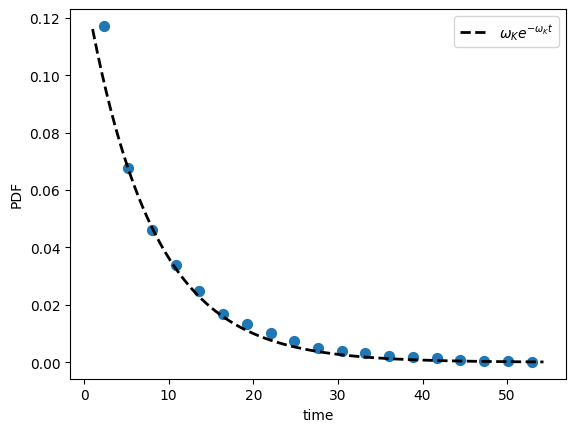

In [10]:
tmin=1
tmax=np.percentile(durs,99.9)
freqs,bin_edges = np.histogram(durs, bins=np.linspace(tmin,tmax,20), density=True)
centers = (bin_edges[1:]+bin_edges[:-1])/2
plt.scatter(centers,freqs,marker='o',s=50)
times = np.linspace(tmin,tmax,100)
_,b=np.polyfit(centers,np.log(freqs),1) #just to get the offset
rate_kramers = 2*kramers_rate(mu,Tx) #2x because here we are estimating only the time to the boundary, not to the other well
plt.plot(times,np.exp(b)*np.exp(-rate_kramers*times),c='k',lw=2,ls='--',label=r'$\omega_K e^{-\omega_K t}$')
plt.ylabel('PDF')
plt.xlabel('time')
plt.legend()
plt.show()

# Extracting slow modes through a transfer operator picture of the dynamics

Using the methods above, we could use our knowledge of the potential landscape to direclty infer the transition boundary and the time it takes to transition across.

However, in most complex systems, the long-lived properties of the dynamics are not immediately apparent from the equations, and analytical solutions are challenging to obtain.

Nonetheless, we can still use the Fokker-Planck dynamics, and particularly the structure to the transfer operator evolving the dynamics, to directly uncover the slow modes of the dynamics.


Returning to can write the Fokker-Planck equation for the density $\rho$ dynamics,

$$
\dot{\rho}(x,t) = \partial_x\left(\partial_x V(x) \rho(x,t) \right) + T_x\partial_x^2 \rho(x,t),
$$

which we can rewrite as,

$$
\dot{\rho}(x,t) = L \rho(x,t)
$$

where $L = \partial_x\left(\partial_x V(x) \cdot \right) + T_x\partial_x^2\cdot$, is the forward Fokker-Planck operator, a linear operator that determines the evolution of probability distributions in the state space driven by the nonlinear Langevin dynamics encoded in $V(x)$. Encoding the nonlinear dynamics through a linear operator is extremely powerful, as the operator's eigenvalues and eigenvectors directly capture the timescales of the system and the corresponding directions, as we'll see in detail below. In addition, we can efficiently approximate the transition operator directly from observations (as we will see in subsequent notebooks), offering a direct means to obtain a coarse-grained desccription of the dynamics with a well-defined timescale separation.

But before we get there, let's first gain intution for structure of this operator by approximating it numerically.

## Finite-difference estimator of the transfer operator

Here, we will make use of the Chang-Cooper method to numerically approximate $L$ through finite-differences (Change, Cooper. *A Practical Difference Scheme for Fokker-Planck Equations*. J. Comput. Physics 1969)

In [11]:
import scipy.sparse as sp
import scipy.sparse.linalg as spla


def fokker_planck_L_sg(x, mu, Tx, boundary="reflecting",potential=None):
    """
    Build L for ∂_t p = ∂_x(∂_x V p) + Tx ∂_x^2 p on a uniform grid x (Chang-Cooper).
    potential(x): callable returning V(x)
    """
    x = np.asarray(x); N = x.size
    dx = x[1] - x[0]; D = Tx

    # Bernoulli function
    def B(z):
        out = np.empty_like(z)
        small = np.abs(z) < 1e-10
        out[~small] = z[~small] / np.expm1(z[~small])
        zS = z[small]
        out[small] = 1 - zS/2 + zS**2/12
        return out

    V = potential(x,mu)
    dV_face = V[1:] - V[:-1]
    psi = -(dV_face) / D

    a = (D / dx**2) * B(psi)      # coeff to node i+1 from face i+1/2
    b = (D / dx**2) * B(-psi)     # coeff to node i   from face i+1/2

    diag  = np.zeros(N)
    upper = np.zeros(N-1)
    lower = np.zeros(N-1)

    # interior
    diag[1:-1]  = -(b[1:] + a[:-1])
    upper[1:-1] =  a[1:-1]
    lower[0:-1] =  b[0:-1]

    if boundary == "reflecting":
        diag[0]   = -b[0];   upper[0]  =  a[0]
        diag[-1]  = -a[-1];  lower[-1] =  b[-1]; upper[-1] =  a[-1]
    elif boundary == "absorbing":
        diag[0] = upper[0] = 0.0
        diag[-1] = lower[-1] = 0.0
        lower[0] = 0.0
        upper[-1] = 0.0
    else:
        raise ValueError("boundary must be 'reflecting' or 'absorbing'")

    L = sp.diags([lower, diag, upper], offsets=[-1,0,1], format="csc")
    return L

N = 1000

x_min, x_max = -np.sqrt(np.abs(mu))-2*np.sqrt(Tx),np.sqrt(np.abs(mu))+2*np.sqrt(Tx)
x = np.linspace(x_min, x_max, N)
V = lambda x,mu: x**4 / 4 - mu * x**2 / 2

L_fp = fokker_planck_L_sg(x,mu,Tx,potential=V)

Now we can directly simulate the dynamics of the entire probability distribution function, rather than a single trajectory. For example, starting from a delta function, we can evolve the dynamics by taking,

$$
\rho(t+\tau) = P_\tau \rho(t),
$$

where $P_\tau = e^{L \tau}$ is the discrete time transition matrix, also known as the forward propagator.



In [12]:
print('Obtain transition matrix')
delay=2e-1
P_tau = spla.expm(delay * L_fp)

print('Iterate probability distribution function')
p0 = np.zeros(P_tau.shape[0]) # set initial condition as a delta function
p0[200] = 1
n_iters=200
p=p0
ps=np.zeros((n_iters,p.shape[0]))
ps[0]=p
for k in range(1,n_iters): #iterate the dynamics
    p = P_tau @ p
    ps[k]=p

Obtain transition matrix
Iterate probability distribution function


You can now observe the relaxation of the probability distribution to the steady state, which we know is given by the Boltzmann distribution

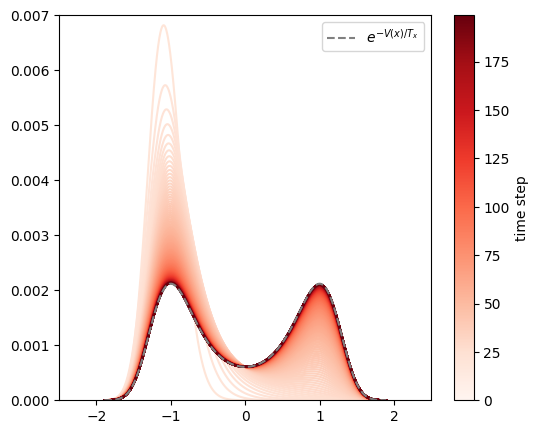

In [13]:
import matplotlib as mpl

ds = 1
n = int(len(ps)/ds)
colors_c = plt.cm.Reds(np.linspace(0.1, 1, n))

plt.figure(figsize=(6,5))
for k, k_ in enumerate(np.arange(1, len(ps), ds)):
    p = ps[k_]
    plt.plot(x, p, c=colors_c[k])

plt.xlim(-2.5, 2.5)
plt.ylim(0, 0.007)

norm = mpl.colors.Normalize(vmin=0, vmax=n-1)
sm = mpl.cm.ScalarMappable(cmap=plt.cm.Reds, norm=norm)
sm.set_array([])

ax = plt.gca()
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("time step")
pB = np.exp(-V(x,mu)/Tx)
pB = pB/np.sum(pB)
plt.plot(x,pB,c='gray',ls='--',label=r'$e^{-V(x)/T_x}$')
plt.legend()
plt.show()


In [14]:
# # For an animation uncomment this code

# import matplotlib.animation as animation
# from IPython.display import HTML
# import matplotlib as mpl

# ds = 1
# frames = np.arange(1, len(ps), ds)

# fig, ax = plt.subplots(figsize=(6,5))

# line, = ax.plot([], [], lw=2)
# line_B, = ax.plot([], [], c='gray', ls='--', label='pB')

# ax.set_xlim(-2.5, 2.5)
# ax.set_ylim(0, 0.07)
# ax.set_xlabel("x")
# ax.set_ylabel("p(x,t)")

# # Boltzmann reference
# pB = np.exp(-V(x,mu)/Tx)
# pB = pB / np.sum(pB)
# line_B.set_data(x, pB)

# # Color map
# cmap = plt.cm.Reds
# norm = mpl.colors.Normalize(vmin=0, vmax=len(frames))

# def init():
#     line.set_data([], [])
#     return line, line_B

# def animate(i):
#     p = ps[frames[i]]
#     line.set_data(x, p)
#     line.set_color(cmap(norm(i)))
#     ax.set_title(f"time step = {frames[i]}")
#     return line, line_B

# ani = animation.FuncAnimation(
#     fig, animate, init_func=init,
#     frames=len(frames), interval=30, blit=True
# )

# plt.close(fig)

# HTML(ani.to_jshtml())


## Decomposing the dynamics into it's long-lived modes

The eigenvalues of $L$, $\Lambda_k$ directly capture the relaxation timescales of different eigenvectors. From practical reasons that become more apparent when we apply this formalism to real data, we will work directly with the discrete time operator $P_\tau$, which preserves the eigenspectrum properties from an appropriate $\tau$. Indeed, since $P_\tau = e^{L \tau}$ the eigenvalue decomposition yields,

$$
P_\tau \psi_k = \lambda_k \psi_k = e^{\Lambda_k \tau} \psi_k,
$$

and so
$$
\lambda_k = e^{\Lambda_k \tau}.
$$


$P_\tau$ always has an eigenvector of eigenvalue 1, which corresponds to the steady-state distribution since it's unchanged when acted by $P_\tau$, $P_\tau \pi = \pi$. For the dynamics we are studying, this should directly correspond to the Botlzmann distribution. Let's check

In [15]:
eigvals_fwd,eigvecs_fwd = op_calc.sorted_spectrum(P_tau,k=2)
pi = eigvecs_fwd[:,0].real/eigvecs_fwd[:,0].real.sum()

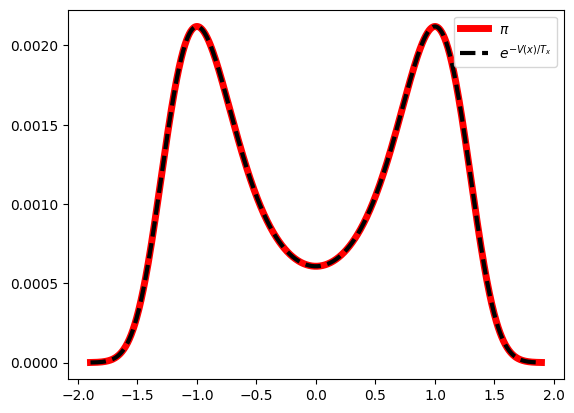

In [16]:
plt.plot(x,pi,c='r',lw=5,label=r'$\pi$')
plt.plot(x,pB,c='k',ls='--',lw=3,label=r'$e^{-V(x)/T_x}$')
plt.legend()
plt.show()

So the first right eigenvector of $P_\tau$ corresponds to the steady-state distribution. The remaining eigenvectors decay to the steady-state distribution on a timescale given by

$$
\Lambda^{-1}_k = -\frac{\tau}{\log \lambda_k}.
$$

For our system, the slowest timescale of the dynamics can be obtained by the transition rate. For a double well, the relaxation rate $\Lambda_1$ is given by

$$
\Lambda_1 = \omega_{AB} + \omega_{BA}
$$

where $A$ and $B$ represent the two wells (see e.g. Risken, *The Fokker-Planck Equation: Methods of Solution and Applications*, 1989). For a symmetric double well, $\omega_{AB}=\omega_{BA}$ and therefore

$$\Lambda_1 = 2\omega$$

So the rates are given by:

In [17]:
print(r'Relaxation rate from transition matrix: {:.3f} Hz'.format(-np.log(eigvals_fwd[1].real)/delay))
print(r'Relaxation rate from Kramers approximation: {:.3f} Hz'.format(2*kramers_rate(mu,Tx)))

Relaxation rate from transition matrix: 0.135 Hz
Relaxation rate from Kramers approximation: 0.129 Hz


In [18]:
print(r'Relaxation time from transition matrix: {:.3f}s'.format(-delay/np.log(eigvals_fwd[1].real)))
print(r'Relaxation time from Kramers approximation: {:.3f}s'.format(1/(2*kramers_rate(mu,Tx))))


Relaxation time from transition matrix: 7.419s
Relaxation time from Kramers approximation: 7.754s


The left eigenvectors of the operator $\phi_k$ capture directions in the state-space that communicate the least: in this case, it corresponds to the direction that goes from one well to the other.

In [19]:
_,eigvecs_bw = op_calc.sorted_spectrum(P_tau.T,k=5)

eigvecs_bw = eigvecs_bw.real
eigvecs_bw = eigvecs_bw/np.linalg.norm(eigvecs_bw,axis=0)

phi2 = eigvecs_bw[:,1]

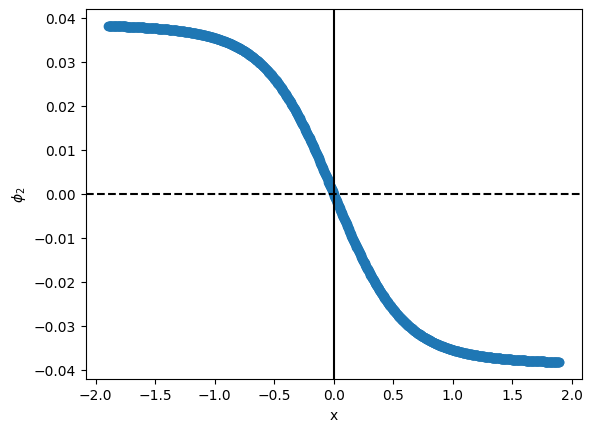

In [20]:
plt.scatter(x,phi2)
plt.axvline(0,c='k')
plt.axhline(0,c='k',ls='--')
plt.ylabel(r'$\phi_2$')
plt.xlabel('x')
plt.show()

As you can see, the sign of $\phi_2$ effectively splits the systems into the two potential wells.

More generally, in systems for which the location of the border between metastable states or almost invariant sets is not immediately apparent from the equations of motion, we can still use the structure of the inferred transfer operator to identify such regions.

We call a set $S$ coherent when the system is more likely to remain within the set than it is to leave it within a time $\tau$. We quantify this intuition through

$$
\chi_{\mu,\tau}(S) = \frac{\mu(S\cap \Phi_{-\tau}S)}{\mu(S)} = \frac{\mu(\Phi_\tau S\cap S)}{\mu(S)},
$$

where $\mu$ is the invariant measure preserved by the invertible flow $\Phi_\tau$. Given an inferred transfer operator $P_\tau$ and its associated stationary eigenvector $\pi$, we can immediately compute $\chi$ as

$$
\chi_{\pi,\tau}(S) = \frac{\sum_{i,j\in S}\pi_i P_{ij}(\tau)}{\sum_{i \in S} \pi_i}.
$$

It turns out that the second eigenvector of the reversibilized transfer operator $\phi_2$ provides an optimal subdivision of the state space into almost invariant sets (see Froyland et al Physica D 2005). And so instead of a brute force search for the sets that maximize the coherence, we can search along $\phi_2$ for a maximum of the overall coherence of both sets,
$$
\chi(\phi_2^c) = \text{min}\{\chi_{\pi,\tau^*}(S^+(\phi_2^c)),\chi_{\pi,\tau^*}(S^-(\phi_2^c))\}
$$

where $\{S^+(\phi_2^c),S^-(\phi_2^c)\}$ result from a partition at $\phi_2^c$.

In [21]:
cr,rho_sets,ms,idx,km_labels = cgm.optimal_partition(phi2,pi,P_tau.T,return_rho=True)

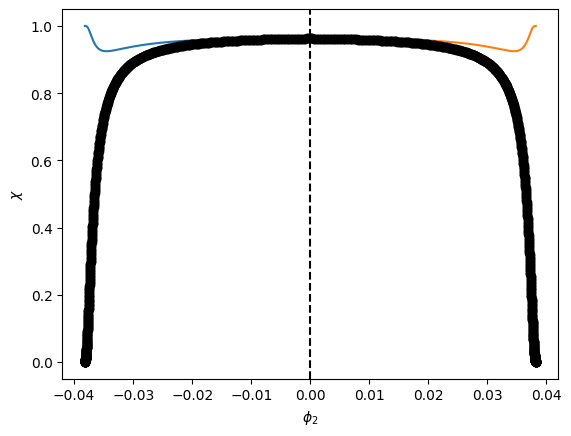

In [22]:
plt.plot(cr,rho_sets)
plt.plot(cr,np.min(rho_sets,axis=1),marker='o',c='k')
plt.axvline(cr[idx],c='k',ls='--')
plt.ylabel(r'$\chi$')
plt.xlabel(r'$\phi_2$')
plt.show()

Using this approach, we can directly identify the slow timescales and corresponding slow modes of the dynamics, as well as the position of the energy barrier, directly from the structure of the transfer operator. In the next notebook, we will see how to infer the operator directly from time series data, and how to recover the slow dynamics.

# Appendix

The Kramers approximation only holds when $\mu/T_x>>1$. If you want a more exact solution, you'll need to solve,

$$
L^*\tau_{MFPT}(x_0) = -1,
$$

which is given by,

$$
\tau_{MFPT} = \frac{1}{T_x}∫_{x_0}^{x_f} e^{V(y)/Tx} dy ∫_{x_L}^y e^{-V(z)/Tx} dz ,
$$

where $x_0$, $x_f$ and $x_L$ are the minimum, the maximum and the reflective boundary at the edge of the potential respectively. For the purposes of this tutorial the Kramers' rate presented above should suffice, but we leave here also a way to directly estimate the mean first passage time to the barrier (see e.g. Costa et al. Fluctuating Landscapes and Heavy Tails in Animal Behavior. PRX Life. 2024)


In [23]:
from scipy.integrate import cumulative_trapezoid

def escape_rate(mu, Tx, N=5000):
    """
    x0 : initial position
    xf : absorbing boundary (barrier location)
    Tx : noise strength (temperature)
    N  : grid resolution
    """
    x0 = -np.sqrt(mu)
    xf = 0
    xL = -np.sqrt(mu) - 10*np.sqrt(Tx) #set reflecting boundary

    # spatial grid
    x = np.linspace(xL, xf, N)

    Vx = x**4/4-mu*x**2/2

    # inner integral: I(y) = ∫_{xL}^y exp(-V(z)/Tx) dz
    inner = cumulative_trapezoid(np.exp(-Vx / Tx), x, initial=0)

    # outer integral: ∫_{x0}^{xf} exp(V(y)/Tx) I(y) dy
    mask = x >= x0
    tau = np.trapezoid(np.exp(Vx[mask] / Tx) * inner[mask], x[mask]) / Tx

    return 1/(tau)

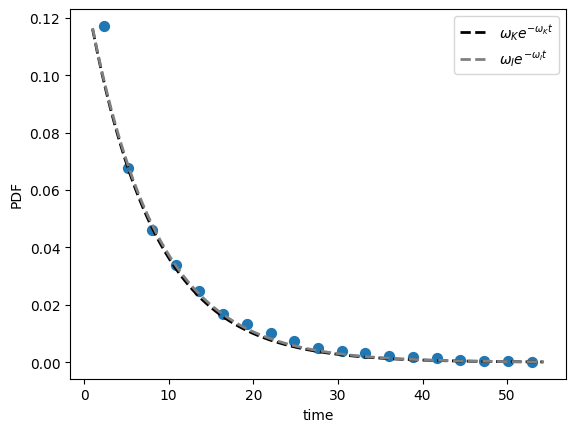

In [24]:
tmin=1
tmax=np.percentile(durs,99.9)
freqs,bin_edges = np.histogram(durs, bins=np.linspace(tmin,tmax,20), density=True)
centers = (bin_edges[1:]+bin_edges[:-1])/2
plt.scatter(centers,freqs,marker='o',s=50)
times = np.linspace(tmin,tmax,100)
_,b=np.polyfit(centers,np.log(freqs),1) #just to get the offset
rate_kramers = 2*kramers_rate(mu,Tx) #2x because here we are estimating only the time to the boundary, not to the other well
plt.plot(times,np.exp(b)*np.exp(-rate_kramers*times),c='k',lw=2,ls='--',label=r'$\omega_K e^{-\omega_K t}$')
rate_int = escape_rate(mu,Tx) #if you want to check against the direct calculation of the mean first passage time
plt.plot(times,np.exp(b)*np.exp(-rate_int*times),c='gray',lw=2,ls='--',label=r'$\omega_I e^{-\omega_I t}$')
plt.ylabel('PDF')
plt.xlabel('time')
plt.legend()
plt.show()